# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=30,
        fold=5,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_12-44-19/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5078 | MulticlassF1Score=0.1667
Batch-30 : CrossEntropyLoss=2.4971 | MulticlassF1Score=0.2101
Batch-45 : CrossEntropyLoss=2.4823 | MulticlassF1Score=0.2266
Batch-60 : CrossEntropyLoss=2.4711 | MulticlassF1Score=0.2491
Batch-75 : CrossEntropyLoss=2.4512 | MulticlassF1Score=0.2744
Batch-90 : CrossEntropyLoss=2.4125 | MulticlassF1Score=0.3096
Batch-105: CrossEntropyLoss=2.3970 | MulticlassF1Score=0.3377
Batch-120: CrossEntropyLoss=2.3748 | MulticlassF1Score=0.3663
Batch-135: CrossEntropyLoss=2.3584 | MulticlassF1Score=0.3918
Batch-150: CrossEntropyLoss=2.3345 | MulticlassF1Score=0.4169
Batch-165: CrossEntropyLoss=2.3599 | MulticlassF1Score=0.4404
Batch-180: CrossEntropyLoss=2.3451 | MulticlassF1Score=0.4592
Batch-195: CrossEntropyLoss=2.3420 | MulticlassF1Score=0.4763
Batch-210: CrossEntropyLoss=2.3696 | MulticlassF1Score=0.4895
Batch-225: CrossEntropyLoss=2.3466 | MulticlassF1Score=0.5015
Batch-226: CrossEntropyLoss=2.3555 | MulticlassF1Score=0.5020

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3460 | MulticlassF1Score=0.6629
Batch-30 : CrossEntropyLoss=2.3328 | MulticlassF1Score=0.6661
Batch-45 : CrossEntropyLoss=2.3430 | MulticlassF1Score=0.6686
Batch-60 : CrossEntropyLoss=2.3613 | MulticlassF1Score=0.6683
Batch-63 : CrossEntropyLoss=2.3533 | MulticlassF1Score=0.6694

Training   : Mean CrossEntropyLoss = 2.4137 | Mean MulticlassF1Score = 0.3437
Validation : Mean CrossEntropyLoss = 2.3507 | Mean MulticlassF1Score = 0.6660

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3345 | MulticlassF1Score=0.6743
Batch-30 : CrossEntropyLoss=2.3527 | MulticlassF1Score=0.6766
Batch-45 : CrossEntropyLoss=2.3533 | MulticlassF1Score=0.6779
Batch-60 : CrossEntropyLoss=2.3482 | MulticlassF1Score=0.6777
Batch-75 : CrossEntropyLoss=2.3458 | MulticlassF1Score=0.6812
Batch-90 : CrossEntropyLoss=2.3173 | MulticlassF1Score=0.6875
Batch-105: CrossEntropyLoss=2.3294 | MulticlassF1Score=0.6925
Batch-120: CrossEntropyLoss=2.3248 | MulticlassF1Score=0.6956
Batch-135: CrossEntropyLoss=2.3387 | MulticlassF1Score=0.6978
Batch-150: CrossEntropyLoss=2.3324 | MulticlassF1Score=0.7006
Batch-165: CrossEntropyLoss=2.3379 | MulticlassF1Score=0.7020
Batch-180: CrossEntropyLoss=2.3388 | MulticlassF1Score=0.7037
Batch-195: CrossEntropyLoss=2.3282 | MulticlassF1Score=0.7053
Batch-210: CrossEntropyLoss=2.3280 | MulticlassF1Score=0.7072
Batch-225: CrossEntropyLoss=2.3207 | MulticlassF1Score=0.7086
Batch-226: CrossEntropyLoss=2.3372 | MulticlassF1Score=0.7086

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3238 | MulticlassF1Score=0.7556
Batch-30 : CrossEntropyLoss=2.3297 | MulticlassF1Score=0.7558
Batch-45 : CrossEntropyLoss=2.3202 | MulticlassF1Score=0.7571
Batch-60 : CrossEntropyLoss=2.3437 | MulticlassF1Score=0.7560
Batch-63 : CrossEntropyLoss=2.3301 | MulticlassF1Score=0.7566

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3388 | Mean MulticlassF1Score = 0.6918
Validation : Mean CrossEntropyLoss = 2.3265 | Mean MulticlassF1Score = 0.7562

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3196 | MulticlassF1Score=0.7705
Batch-30 : CrossEntropyLoss=2.3085 | MulticlassF1Score=0.7763
Batch-45 : CrossEntropyLoss=2.3207 | MulticlassF1Score=0.7799
Batch-60 : CrossEntropyLoss=2.3166 | MulticlassF1Score=0.7806
Batch-75 : CrossEntropyLoss=2.3178 | MulticlassF1Score=0.7834
Batch-90 : CrossEntropyLoss=2.3041 | MulticlassF1Score=0.7845
Batch-105: CrossEntropyLoss=2.3084 | MulticlassF1Score=0.7848
Batch-120: CrossEntropyLoss=2.3151 | MulticlassF1Score=0.7867
Batch-135: CrossEntropyLoss=2.3219 | MulticlassF1Score=0.7864
Batch-150: CrossEntropyLoss=2.3170 | MulticlassF1Score=0.7873
Batch-165: CrossEntropyLoss=2.3063 | MulticlassF1Score=0.7887
Batch-180: CrossEntropyLoss=2.3114 | MulticlassF1Score=0.7896
Batch-195: CrossEntropyLoss=2.3060 | MulticlassF1Score=0.7896
Batch-210: CrossEntropyLoss=2.3058 | MulticlassF1Score=0.7902
Batch-225: CrossEntropyLoss=2.3099 | MulticlassF1Score=0.7904
Batch-226: CrossEntropyLoss=2.3095 | MulticlassF1Score=0.7903

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3072 | MulticlassF1Score=0.7900
Batch-30 : CrossEntropyLoss=2.3219 | MulticlassF1Score=0.7909
Batch-45 : CrossEntropyLoss=2.3293 | MulticlassF1Score=0.7892
Batch-60 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.7895
Batch-63 : CrossEntropyLoss=2.3273 | MulticlassF1Score=0.7896

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3133 | Mean MulticlassF1Score = 0.7841
Validation : Mean CrossEntropyLoss = 2.3129 | Mean MulticlassF1Score = 0.7898

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.7930
Batch-30 : CrossEntropyLoss=2.3128 | MulticlassF1Score=0.7908
Batch-45 : CrossEntropyLoss=2.3066 | MulticlassF1Score=0.7922
Batch-60 : CrossEntropyLoss=2.3223 | MulticlassF1Score=0.7938
Batch-75 : CrossEntropyLoss=2.3095 | MulticlassF1Score=0.7956
Batch-90 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.7980
Batch-105: CrossEntropyLoss=2.3126 | MulticlassF1Score=0.7998
Batch-120: CrossEntropyLoss=2.3086 | MulticlassF1Score=0.8013
Batch-135: CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8041
Batch-150: CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8066
Batch-165: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8086
Batch-180: CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8095
Batch-195: CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8101
Batch-210: CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8112
Batch-225: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8126
Batch-226: CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8126

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3079 | MulticlassF1Score=0.8222
Batch-30 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8247
Batch-45 : CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8243
Batch-60 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8226
Batch-63 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8224

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3061 | Mean MulticlassF1Score = 0.8015
Validation : Mean CrossEntropyLoss = 2.3027 | Mean MulticlassF1Score = 0.8238

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8341
Batch-30 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8348
Batch-45 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8324
Batch-60 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8316
Batch-75 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8302
Batch-90 : CrossEntropyLoss=2.3076 | MulticlassF1Score=0.8302
Batch-105: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8301
Batch-120: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8303
Batch-135: CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8300
Batch-150: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8298
Batch-165: CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8290
Batch-180: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8288
Batch-195: CrossEntropyLoss=2.3095 | MulticlassF1Score=0.8294
Batch-210: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8300
Batch-225: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8301
Batch-226: CrossEntropyLoss=2.3103 | MulticlassF1Score=0.8299

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3088 | MulticlassF1Score=0.8188
Batch-30 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8221
Batch-45 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8241
Batch-60 : CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8245
Batch-63 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8237

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3005 | Mean MulticlassF1Score = 0.8311
Validation : Mean CrossEntropyLoss = 2.3021 | Mean MulticlassF1Score = 0.8214

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3163 | MulticlassF1Score=0.8273
Batch-30 : CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8299
Batch-45 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8295
Batch-60 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8292
Batch-75 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8305
Batch-90 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8319
Batch-105: CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8315
Batch-120: CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8313
Batch-135: CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8311
Batch-150: CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8312
Batch-165: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8313
Batch-180: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8317
Batch-195: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8320
Batch-210: CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8320
Batch-225: CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8317
Batch-226: CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8317

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3096 | MulticlassF1Score=0.8215
Batch-30 : CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8238
Batch-45 : CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8242
Batch-60 : CrossEntropyLoss=2.3115 | MulticlassF1Score=0.8243
Batch-63 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8245

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2997 | Mean MulticlassF1Score = 0.8307
Validation : Mean CrossEntropyLoss = 2.3018 | Mean MulticlassF1Score = 0.8239

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8324
Batch-30 : CrossEntropyLoss=2.3146 | MulticlassF1Score=0.8320
Batch-45 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8327
Batch-60 : CrossEntropyLoss=2.3063 | MulticlassF1Score=0.8328
Batch-75 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8337
Batch-90 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8332
Batch-105: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8338
Batch-120: CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8336
Batch-135: CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8340
Batch-150: CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8340
Batch-165: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8338
Batch-180: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8347
Batch-195: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8353
Batch-210: CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8361
Batch-225: CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8369
Batch-226: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8369

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8415
Batch-30 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8388
Batch-45 : CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8373
Batch-60 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8396
Batch-63 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8401

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2983 | Mean MulticlassF1Score = 0.8337
Validation : Mean CrossEntropyLoss = 2.2971 | Mean MulticlassF1Score = 0.8400

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8511
Batch-30 : CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8490
Batch-45 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8496
Batch-60 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8496
Batch-75 : CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8499
Batch-90 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8514
Batch-105: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8528
Batch-120: CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8530
Batch-135: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8526
Batch-150: CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8535
Batch-165: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8542
Batch-180: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8547
Batch-195: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8551
Batch-210: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8558
Batch-225: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8555
Batch-226: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8556

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8517
Batch-30 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8497
Batch-45 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8498
Batch-60 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8521
Batch-63 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8518

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2926 | Mean MulticlassF1Score = 0.8524
Validation : Mean CrossEntropyLoss = 2.2935 | Mean MulticlassF1Score = 0.8508

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8608
Batch-30 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8645
Batch-45 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8615
Batch-60 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8614
Batch-75 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8607
Batch-90 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8615
Batch-105: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8611
Batch-120: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8614
Batch-135: CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8616
Batch-150: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8611
Batch-165: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8611
Batch-180: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8611
Batch-195: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8615
Batch-210: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8614
Batch-225: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8614
Batch-226: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8614

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8574
Batch-30 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8550
Batch-45 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8541
Batch-60 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8525
Batch-63 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8531

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2907 | Mean MulticlassF1Score = 0.8609
Validation : Mean CrossEntropyLoss = 2.2930 | Mean MulticlassF1Score = 0.8553

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8646
Batch-30 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8643
Batch-45 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8669
Batch-60 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8654
Batch-75 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8651
Batch-90 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8642
Batch-105: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8645
Batch-120: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8642
Batch-135: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8639
Batch-150: CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8643
Batch-165: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8639
Batch-180: CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8638
Batch-195: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8637
Batch-210: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8652
Batch-225: CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8667
Batch-226: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8667

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8834
Batch-30 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8785
Batch-45 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8805
Batch-60 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8796
Batch-63 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8792

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2890 | Mean MulticlassF1Score = 0.8647
Validation : Mean CrossEntropyLoss = 2.2855 | Mean MulticlassF1Score = 0.8806

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8912
Batch-30 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8928
Batch-45 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8915
Batch-60 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8912
Batch-75 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8914
Batch-90 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8905
Batch-105: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.8904
Batch-120: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8907
Batch-135: CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8906
Batch-150: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8909
Batch-165: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8916
Batch-180: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8917
Batch-195: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8917
Batch-210: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8917
Batch-225: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8915
Batch-226: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8916

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8880
Batch-30 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8829
Batch-45 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8826
Batch-60 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8816
Batch-63 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8816

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2816 | Mean MulticlassF1Score = 0.8911
Validation : Mean CrossEntropyLoss = 2.2844 | Mean MulticlassF1Score = 0.8847

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9012
Batch-30 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8982
Batch-45 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8988
Batch-60 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.8972
Batch-75 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8967
Batch-90 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8963
Batch-105: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8959
Batch-120: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8948
Batch-135: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8951
Batch-150: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.8954
Batch-165: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8949
Batch-180: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8947
Batch-195: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8946
Batch-210: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8945
Batch-225: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8945
Batch-226: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8944

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8925
Batch-30 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8872
Batch-45 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8867
Batch-60 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8856
Batch-63 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8850

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2805 | Mean MulticlassF1Score = 0.8964
Validation : Mean CrossEntropyLoss = 2.2833 | Mean MulticlassF1Score = 0.8890

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8948
Batch-30 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8935
Batch-45 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8944
Batch-60 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8947
Batch-75 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.8952
Batch-90 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8965
Batch-105: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8970
Batch-120: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8978
Batch-135: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8971
Batch-150: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8963
Batch-165: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8965
Batch-180: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8965
Batch-195: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8966
Batch-210: CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8968
Batch-225: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8966
Batch-226: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8965

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8874
Batch-30 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8877
Batch-45 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8866
Batch-60 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8856
Batch-63 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8859

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2798 | Mean MulticlassF1Score = 0.8960
Validation : Mean CrossEntropyLoss = 2.2829 | Mean MulticlassF1Score = 0.8879

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8997
Batch-30 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8963
Batch-45 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8968
Batch-60 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8982
Batch-75 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8987
Batch-90 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8992
Batch-105: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8988
Batch-120: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8990
Batch-135: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8986
Batch-150: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8984
Batch-165: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.8987
Batch-180: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8988
Batch-195: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.8990
Batch-210: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8987
Batch-225: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8988
Batch-226: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8988

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8815
Batch-30 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8846
Batch-45 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8859
Batch-60 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8857
Batch-63 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8862

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2790 | Mean MulticlassF1Score = 0.8986
Validation : Mean CrossEntropyLoss = 2.2827 | Mean MulticlassF1Score = 0.8835

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8937
Batch-30 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.8963
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.8975
Batch-60 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8977
Batch-75 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8981
Batch-90 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8993
Batch-105: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8996
Batch-120: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8998
Batch-135: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9001
Batch-150: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8999
Batch-165: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9002
Batch-180: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9003
Batch-195: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9002
Batch-210: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9002
Batch-225: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9004
Batch-226: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.9003

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.8873
Batch-30 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8861
Batch-45 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8871
Batch-60 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8869
Batch-63 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8870

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2785 | Mean MulticlassF1Score = 0.8984
Validation : Mean CrossEntropyLoss = 2.2826 | Mean MulticlassF1Score = 0.8871

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9023
Batch-30 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9033
Batch-45 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9024
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9036
Batch-75 : CrossEntropyLoss=2.2894 | MulticlassF1Score=0.9033
Batch-90 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.9022
Batch-105: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9019
Batch-120: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.9017
Batch-135: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9019
Batch-150: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9016
Batch-165: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.9019
Batch-180: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9018
Batch-195: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9016
Batch-210: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9016
Batch-225: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9013
Batch-226: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.9013

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8861
Batch-30 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8868
Batch-45 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.8880
Batch-60 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8870
Batch-63 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8872

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2782 | Mean MulticlassF1Score = 0.9023
Validation : Mean CrossEntropyLoss = 2.2824 | Mean MulticlassF1Score = 0.8875

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.9046
Batch-30 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9006
Batch-45 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.9010
Batch-60 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9017
Batch-75 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9018
Batch-90 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9023
Batch-105: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9023
Batch-120: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9025
Batch-135: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9024
Batch-150: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9024
Batch-165: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9026
Batch-180: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9023
Batch-195: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9020
Batch-210: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9021
Batch-225: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.9021
Batch-226: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9021

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8897
Batch-30 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8874
Batch-45 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8858
Batch-60 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8862
Batch-63 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8860

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2779 | Mean MulticlassF1Score = 0.9025
Validation : Mean CrossEntropyLoss = 2.2828 | Mean MulticlassF1Score = 0.8874

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9034
Batch-30 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9004
Batch-45 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9017
Batch-60 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.9018
Batch-75 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9024
Batch-90 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9028
Batch-105: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.9021
Batch-120: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9026
Batch-135: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9032
Batch-150: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9035
Batch-165: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.9033
Batch-180: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9031
Batch-195: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9032
Batch-210: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9030
Batch-225: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9029
Batch-226: CrossEntropyLoss=2.2897 | MulticlassF1Score=0.9027

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8929
Batch-30 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8881
Batch-45 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8878
Batch-60 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8877
Batch-63 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8876

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2777 | Mean MulticlassF1Score = 0.9026
Validation : Mean CrossEntropyLoss = 2.2822 | Mean MulticlassF1Score = 0.8903

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.9030
Batch-30 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9028
Batch-45 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9033
Batch-60 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9036
Batch-75 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9039
Batch-90 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9044
Batch-105: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9049
Batch-120: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9043
Batch-135: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9046
Batch-150: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9046
Batch-165: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9041
Batch-180: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9042
Batch-195: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9039
Batch-210: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9039
Batch-225: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.9037
Batch-226: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.9036

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8885
Batch-30 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8900
Batch-45 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8901
Batch-60 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8883
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.8888

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2774 | Mean MulticlassF1Score = 0.9042
Validation : Mean CrossEntropyLoss = 2.2819 | Mean MulticlassF1Score = 0.8898

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9051
Batch-30 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9048
Batch-45 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9069
Batch-60 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9079
Batch-75 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9071
Batch-90 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9075
Batch-105: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9074
Batch-120: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9074
Batch-135: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.9076
Batch-150: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9070
Batch-165: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9072
Batch-180: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9072
Batch-195: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9077
Batch-210: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9075
Batch-225: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9076
Batch-226: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9076

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8895
Batch-30 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.8923
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.8924
Batch-60 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8928
Batch-63 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8927

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2761 | Mean MulticlassF1Score = 0.9066
Validation : Mean CrossEntropyLoss = 2.2807 | Mean MulticlassF1Score = 0.8916

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9051
Batch-30 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9064
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9087
Batch-60 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9091
Batch-75 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9090
Batch-90 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9094
Batch-105: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9095
Batch-120: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9098
Batch-135: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9095
Batch-150: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9098
Batch-165: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9096
Batch-180: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9096
Batch-195: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9093
Batch-210: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9090
Batch-225: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9093
Batch-226: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9093

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8942
Batch-30 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8925
Batch-45 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8923
Batch-60 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.8932
Batch-63 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8933

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2756 | Mean MulticlassF1Score = 0.9088
Validation : Mean CrossEntropyLoss = 2.2805 | Mean MulticlassF1Score = 0.8926

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9142
Batch-30 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9111
Batch-45 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9124
Batch-60 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9125
Batch-75 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9114
Batch-90 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9116
Batch-105: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9114
Batch-120: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9108
Batch-135: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9106
Batch-150: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9106
Batch-165: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9106
Batch-180: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.9106
Batch-195: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9104
Batch-210: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9104
Batch-225: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9104
Batch-226: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9104

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8933
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8947
Batch-45 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8955
Batch-60 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8935
Batch-63 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8932

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2752 | Mean MulticlassF1Score = 0.9112
Validation : Mean CrossEntropyLoss = 2.2804 | Mean MulticlassF1Score = 0.8950

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9120
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9125
Batch-45 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9100
Batch-60 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9095
Batch-75 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9108
Batch-90 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9104
Batch-105: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9107
Batch-120: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9111
Batch-135: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9113
Batch-150: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9115
Batch-165: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9116
Batch-180: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9113
Batch-195: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9115
Batch-210: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9111
Batch-225: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9114
Batch-226: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.9114

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8911
Batch-30 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8916
Batch-45 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8920
Batch-60 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8934
Batch-63 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8935

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2749 | Mean MulticlassF1Score = 0.9113
Validation : Mean CrossEntropyLoss = 2.2803 | Mean MulticlassF1Score = 0.8921

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9117
Batch-30 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9118
Batch-45 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9120
Batch-60 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9125
Batch-75 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9126
Batch-90 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9123
Batch-105: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9123
Batch-120: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9141
Batch-135: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9163
Batch-150: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9183
Batch-165: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9197
Batch-180: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9206
Batch-195: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9214
Batch-210: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9226
Batch-225: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9235
Batch-226: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9236

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9109
Batch-30 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9160
Batch-45 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9155
Batch-60 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9165
Batch-63 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9166

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9159
Validation : Mean CrossEntropyLoss = 2.2734 | Mean MulticlassF1Score = 0.9153

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9355
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9368
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9358
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9356
Batch-75 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9350
Batch-90 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9352
Batch-105: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9358
Batch-120: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9362
Batch-135: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9368
Batch-150: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9364
Batch-165: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9364
Batch-180: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9364
Batch-195: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9368
Batch-210: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9373
Batch-225: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9375
Batch-226: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9375

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9223
Batch-30 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9208
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9214
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9220
Batch-63 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9224

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9359
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9220

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9350
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9390
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9404
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9409
Batch-75 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9419
Batch-90 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9423
Batch-105: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9422
Batch-120: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9423
Batch-135: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9419
Batch-150: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9417
Batch-165: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9417
Batch-180: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9414
Batch-195: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9414
Batch-210: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9411
Batch-225: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9409
Batch-226: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9409

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9253
Batch-30 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9235
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9228
Batch-60 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9229
Batch-63 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9230

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9409
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9240

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9400
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9401
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9407
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9404
Batch-75 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9404
Batch-90 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9401
Batch-105: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9405
Batch-120: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9411
Batch-135: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9409
Batch-150: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9407
Batch-165: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9410
Batch-180: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9409
Batch-195: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9412
Batch-210: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9413
Batch-225: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9414
Batch-226: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9415

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9212
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9237
Batch-45 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9236
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9231
Batch-63 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9229

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9410
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9225

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9434
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9439
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9432
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9423
Batch-75 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9420
Batch-90 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9420
Batch-105: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9424
Batch-120: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9423
Batch-135: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9421
Batch-150: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9424
Batch-165: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9423
Batch-180: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9422
Batch-195: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9424
Batch-210: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9421
Batch-225: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9422
Batch-226: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9422

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9230
Batch-30 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9225
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9231
Batch-60 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9230
Batch-63 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9231

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9423
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9228

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9423
Batch-30 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9446
Batch-45 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9452
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9455
Batch-75 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9439
Batch-90 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9429
Batch-105: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9432
Batch-120: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9434
Batch-135: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9429
Batch-150: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9426
Batch-165: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9427
Batch-180: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9426
Batch-195: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9430
Batch-210: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9428
Batch-225: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9428
Batch-226: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9427

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9278
Batch-30 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9246
Batch-45 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9236
Batch-60 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9227
Batch-63 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9228

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9432
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9254

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9445
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9447
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9452
Batch-60 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9449
Batch-75 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9452
Batch-90 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9448
Batch-105: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9440
Batch-120: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9439
Batch-135: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9440
Batch-150: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9437
Batch-165: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9435
Batch-180: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9435
Batch-195: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9433
Batch-210: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9433
Batch-225: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9431
Batch-226: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9431

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9233
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9249
Batch-45 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9227
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9227
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9227

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9441
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9241

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9424
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9422
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9422
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9425
Batch-75 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9431
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9435
Batch-105: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9440
Batch-120: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9437
Batch-135: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9434
Batch-150: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9435
Batch-165: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9433
Batch-180: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9434
Batch-195: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9431
Batch-210: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9431
Batch-225: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9433
Batch-226: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9432

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.9261
Batch-30 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9231
Batch-45 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9243
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9234
Batch-63 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9237

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9430
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9250

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9449
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9455
Batch-45 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9464
Batch-75 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9466
Batch-90 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9460
Batch-105: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9453
Batch-120: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9454
Batch-135: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9445
Batch-150: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9446
Batch-165: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9443
Batch-180: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9440
Batch-195: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9437
Batch-210: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9436
Batch-225: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9433
Batch-226: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9434

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9237
Batch-30 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9240
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9237
Batch-60 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9239
Batch-63 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9236

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9448
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9245

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9427
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9436
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9448
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9438
Batch-75 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9441
Batch-90 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9438
Batch-105: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9439
Batch-120: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9441
Batch-135: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9439
Batch-150: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9440
Batch-165: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9438
Batch-180: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9437
Batch-195: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9438
Batch-210: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9444
Batch-225: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9455
Batch-226: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9455

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9422
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9413
Batch-45 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9416
Batch-60 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9414
Batch-63 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9411

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9441
Validation : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9409

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9610
Batch-30 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9607
Batch-45 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9623
Batch-60 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9621
Batch-75 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9627
Batch-90 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9628
Batch-105: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9624
Batch-120: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9625
Batch-135: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9628
Batch-150: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9632
Batch-165: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9634
Batch-180: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9634
Batch-195: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9632
Batch-210: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9631
Batch-225: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9631
Batch-226: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9631

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9416
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9415
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9421
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9426
Batch-63 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9432

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2590 | Mean MulticlassF1Score = 0.9626
Validation : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9416

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9672
Batch-30 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9638
Batch-45 : CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9634
Batch-60 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9624
Batch-75 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9632
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9637
Batch-105: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9636
Batch-120: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9634
Batch-135: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9635
Batch-150: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9637
Batch-165: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9638
Batch-180: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9637
Batch-195: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9636
Batch-210: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9635
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9633
Batch-226: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9632

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9407
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9417
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9419
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9418
Batch-63 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9417

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2589 | Mean MulticlassF1Score = 0.9639
Validation : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9420

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9647
Batch-30 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9642
Batch-45 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9642
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9642
Batch-75 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9643
Batch-90 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9640
Batch-105: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9642
Batch-120: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9646
Batch-135: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9646
Batch-150: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9645
Batch-165: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9642
Batch-180: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9643
Batch-195: CrossEntropyLoss=2.2519 | MulticlassF1Score=0.9644
Batch-210: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9643
Batch-225: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9640
Batch-226: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9640

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9407
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9428
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9443
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9427
Batch-63 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9427

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2586 | Mean MulticlassF1Score = 0.9643
Validation : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9429

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9627
Batch-30 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9643
Batch-45 : CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9656
Batch-60 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9652
Batch-75 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9647
Batch-90 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9648
Batch-105: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9649
Batch-120: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9649
Batch-135: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9649
Batch-150: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9648
Batch-165: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9646
Batch-180: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9646
Batch-195: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9646
Batch-210: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9646
Batch-225: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9646
Batch-226: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9646

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9433
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9432
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9437
Batch-63 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9435

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9646
Validation : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9451

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9646
Batch-30 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9681
Batch-45 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9672
Batch-60 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9670
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9671
Batch-90 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9668
Batch-105: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9667
Batch-120: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9666
Batch-135: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9667
Batch-150: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9665
Batch-165: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9667
Batch-180: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9668
Batch-195: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9668
Batch-210: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9666
Batch-225: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9664
Batch-226: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9665

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9452
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9448
Batch-60 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9450
Batch-63 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9449

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9665
Validation : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9450

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9647
Batch-30 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9666
Batch-45 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9667
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9662
Batch-75 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9661
Batch-90 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9666
Batch-105: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9668
Batch-120: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9667
Batch-135: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9667
Batch-150: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9669
Batch-165: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9671
Batch-180: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9671
Batch-195: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9670
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9668
Batch-225: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9669
Batch-226: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9669

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9467
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9433
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9435
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9444
Batch-63 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9450

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9667
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9441

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9661
Batch-30 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9661
Batch-45 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9678
Batch-60 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9671
Batch-75 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9672
Batch-90 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9673
Batch-105: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9670
Batch-120: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9669
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9667
Batch-150: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9668
Batch-165: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9670
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9671
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9672
Batch-210: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9673
Batch-225: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9672
Batch-226: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9672

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9441
Batch-30 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9454
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9451
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9447
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9446

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9670
Validation : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9450

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9699
Batch-30 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9679
Batch-45 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9693
Batch-60 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9690
Batch-75 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9683
Batch-90 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9681
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9679
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9676
Batch-135: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9677
Batch-150: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9675
Batch-180: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9674
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9673
Batch-210: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9673
Batch-225: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9673
Batch-226: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9674

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9436
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9437
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9446
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9443
Batch-63 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9445

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9679
Validation : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9444

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9678
Batch-30 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9674
Batch-45 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9670
Batch-60 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9661
Batch-75 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9667
Batch-90 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9666
Batch-105: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9668
Batch-120: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9667
Batch-135: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9669
Batch-150: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9669
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9669
Batch-180: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9672
Batch-195: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9674
Batch-210: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9672
Batch-225: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9673
Batch-226: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9673

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9455
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9448
Batch-45 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9449
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9450
Batch-63 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9447

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9670
Validation : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9451

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9665
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9675
Batch-45 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9670
Batch-60 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9665
Batch-75 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9667
Batch-90 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9670
Batch-105: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9672
Batch-120: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9668
Batch-135: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9672
Batch-150: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9675
Batch-165: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9676
Batch-180: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9675
Batch-195: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9676
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9675
Batch-225: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9674
Batch-226: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9674

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9452
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9447
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9458
Batch-63 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9458

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9671
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9444

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9657
Batch-30 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9664
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9674
Batch-60 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9676
Batch-75 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9676
Batch-90 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9677
Batch-105: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9676
Batch-120: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9674
Batch-135: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9668
Batch-150: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9666
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9667
Batch-180: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9668
Batch-195: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9671
Batch-210: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9671
Batch-225: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9672
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9672

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9439
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9447
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9458
Batch-63 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9456

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9673
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9444
Patience = 1/50❗

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9671
Batch-30 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9679
Batch-45 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9664
Batch-60 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9667
Batch-75 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9670
Batch-90 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9673
Batch-105: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9672
Batch-120: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9675
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9677
Batch-150: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9678
Batch-165: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9678
Batch-180: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9676
Batch-195: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9673
Batch-210: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9677
Batch-225: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9676
Batch-226: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9676

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9440
Batch-30 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9451
Batch-60 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9455
Batch-63 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9453

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9673
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9453

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9672
Batch-30 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9665
Batch-45 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9667
Batch-60 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9670
Batch-75 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9670
Batch-90 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9676
Batch-105: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9680
Batch-120: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9681
Batch-135: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9683
Batch-150: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9680
Batch-165: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9679
Batch-180: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9679
Batch-195: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9679
Batch-210: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9677
Batch-225: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9678
Batch-226: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9678

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9403
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9431
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9446
Batch-60 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9452
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9454

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9677
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9435

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9706
Batch-30 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9708
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9697
Batch-60 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9696
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9691
Batch-90 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9692
Batch-105: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9696
Batch-120: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9693
Batch-135: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9689
Batch-150: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9685
Batch-165: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9685
Batch-180: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9682
Batch-195: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9682
Batch-210: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9682
Batch-225: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9681
Batch-226: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9681

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9466
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9459
Batch-63 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9460

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9692
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9462

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9661
Batch-30 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9668
Batch-45 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9676
Batch-60 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9683
Batch-75 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9681
Batch-90 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9684
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9685
Batch-120: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9684
Batch-135: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9683
Batch-150: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9685
Batch-165: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9685
Batch-180: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9684
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9686
Batch-210: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9685
Batch-225: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9683
Batch-226: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9683

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9455
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9441
Batch-45 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9449
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9456
Batch-63 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9460

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9680
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9455

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9652
Batch-30 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9678
Batch-45 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9683
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9676
Batch-75 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9678
Batch-90 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9683
Batch-105: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9686
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9687
Batch-135: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9688
Batch-150: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9687
Batch-165: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9688
Batch-180: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9688
Batch-195: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9687
Batch-210: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9687
Batch-225: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9686
Batch-226: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9686

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9480
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9454
Batch-60 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9457
Batch-63 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9464

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9683
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9470

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9677
Batch-30 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9701
Batch-45 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9704
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9701
Batch-75 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9695
Batch-90 : CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9694
Batch-105: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9688
Batch-120: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9690
Batch-135: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9689
Batch-150: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9691
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9693
Batch-180: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9690
Batch-195: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9689
Batch-210: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9689
Batch-226: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9689

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9435
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9448
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9461
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9460

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9691
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9445

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2570
Best CrossEntropyLoss training    : 2.2641
Best MulticlassF1Score validation : 0.9691
Best MulticlassF1Score validation : 0.9445
Training duration                 : 2.0002 minutes.
Training date                     : 2022-10-19 09:15:43.715346+08:00


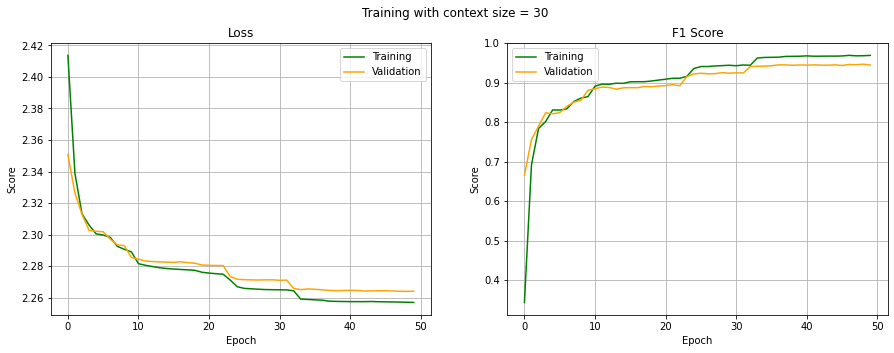

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9692, device='cuda:0'),
 tensor(0.9460, device='cuda:0'),
 tensor(0.9446, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9692, device='cuda:0'),
 tensor(0.9460, device='cuda:0'),
 tensor(0.9446, device='cuda:0'))

## Heatmap

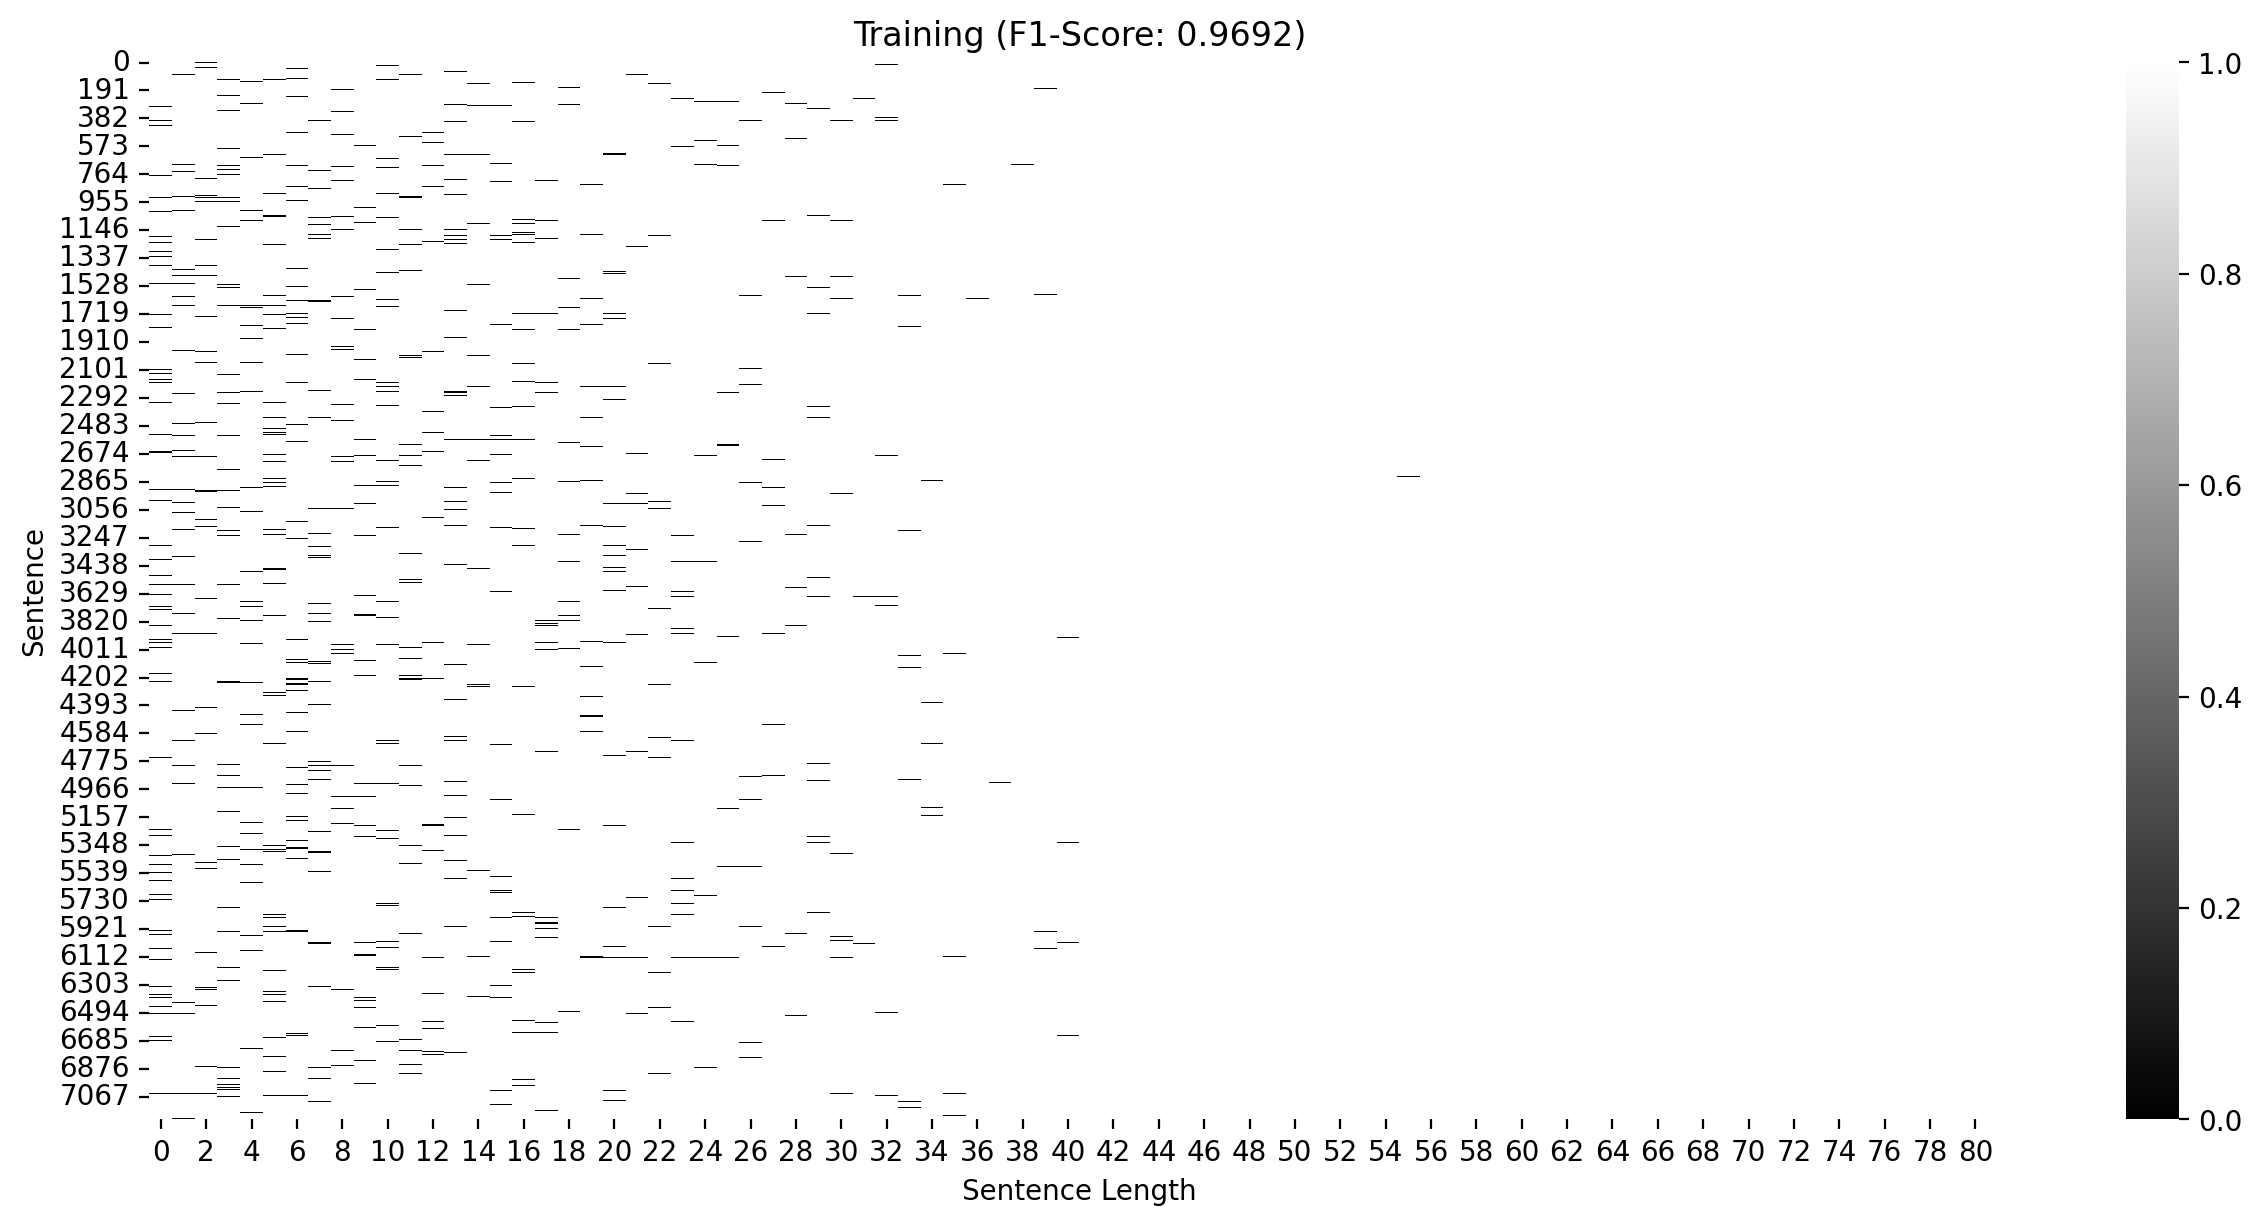

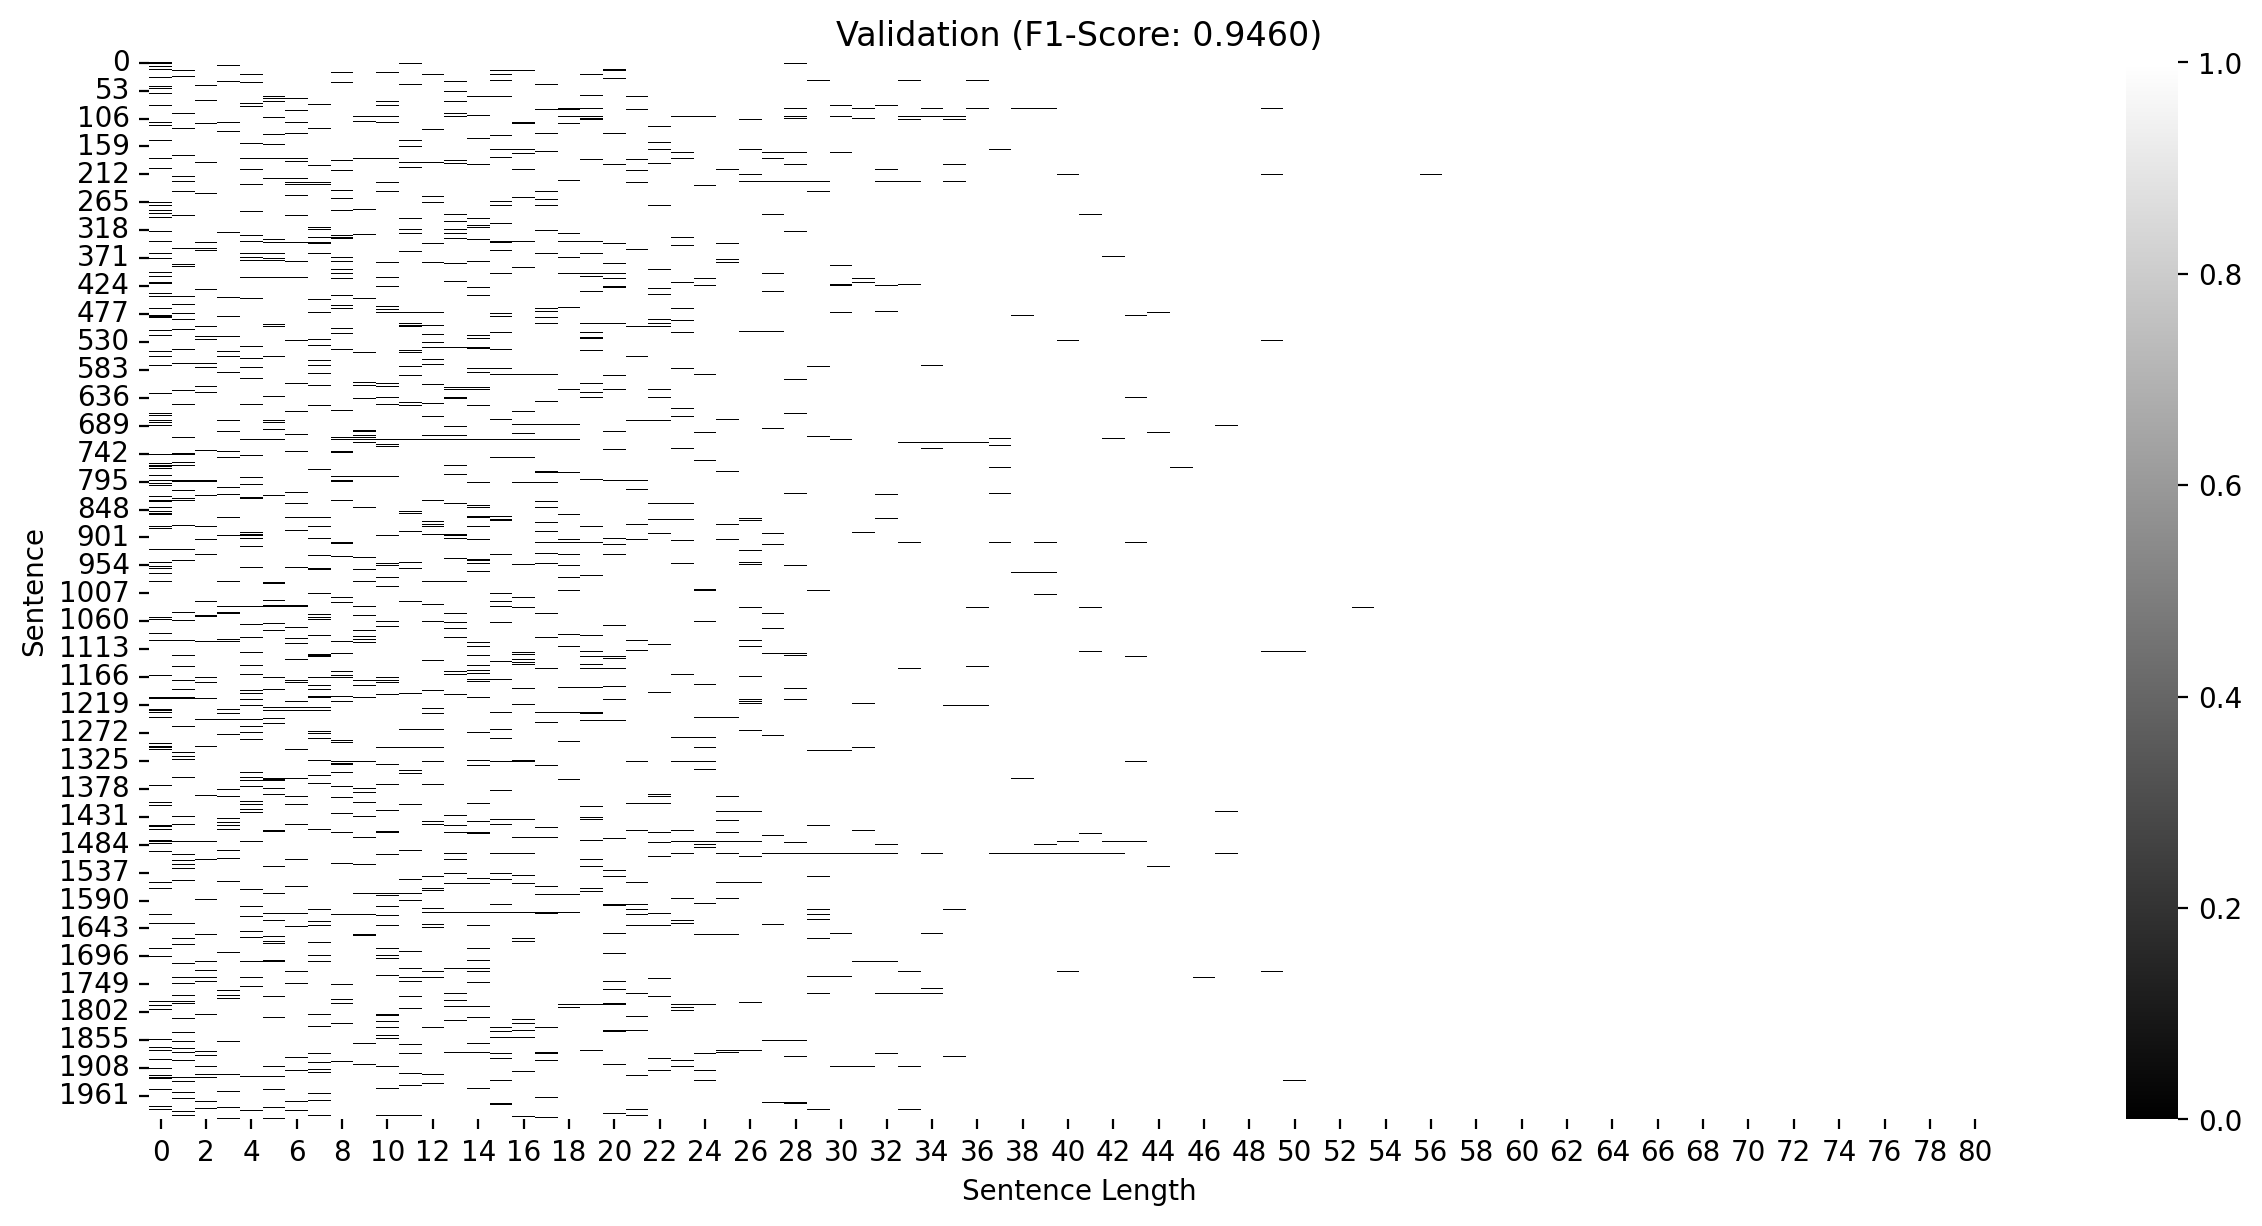

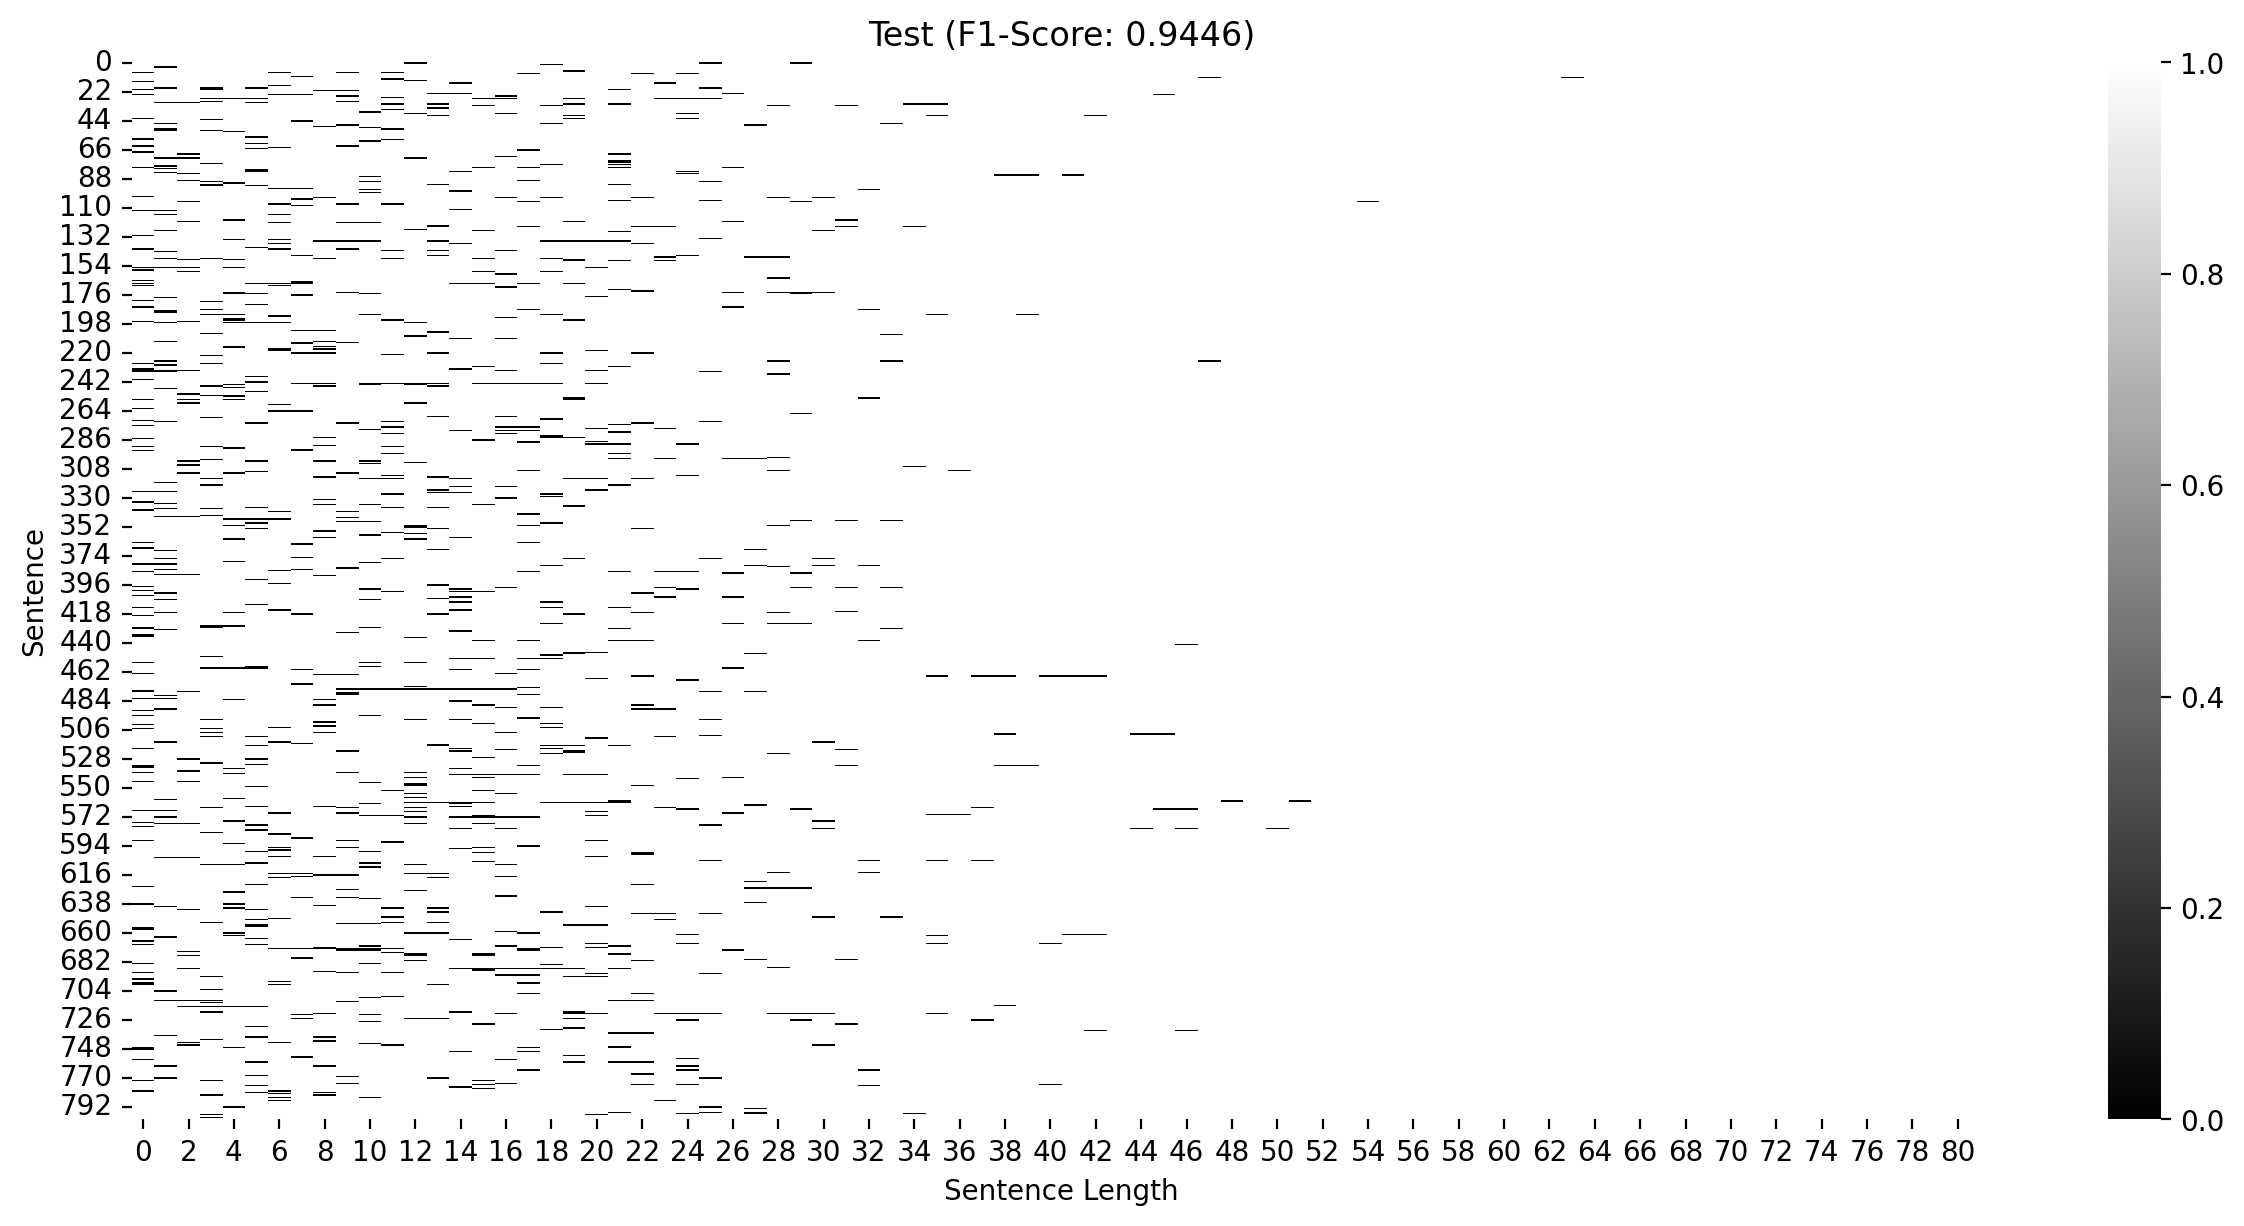

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 96 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


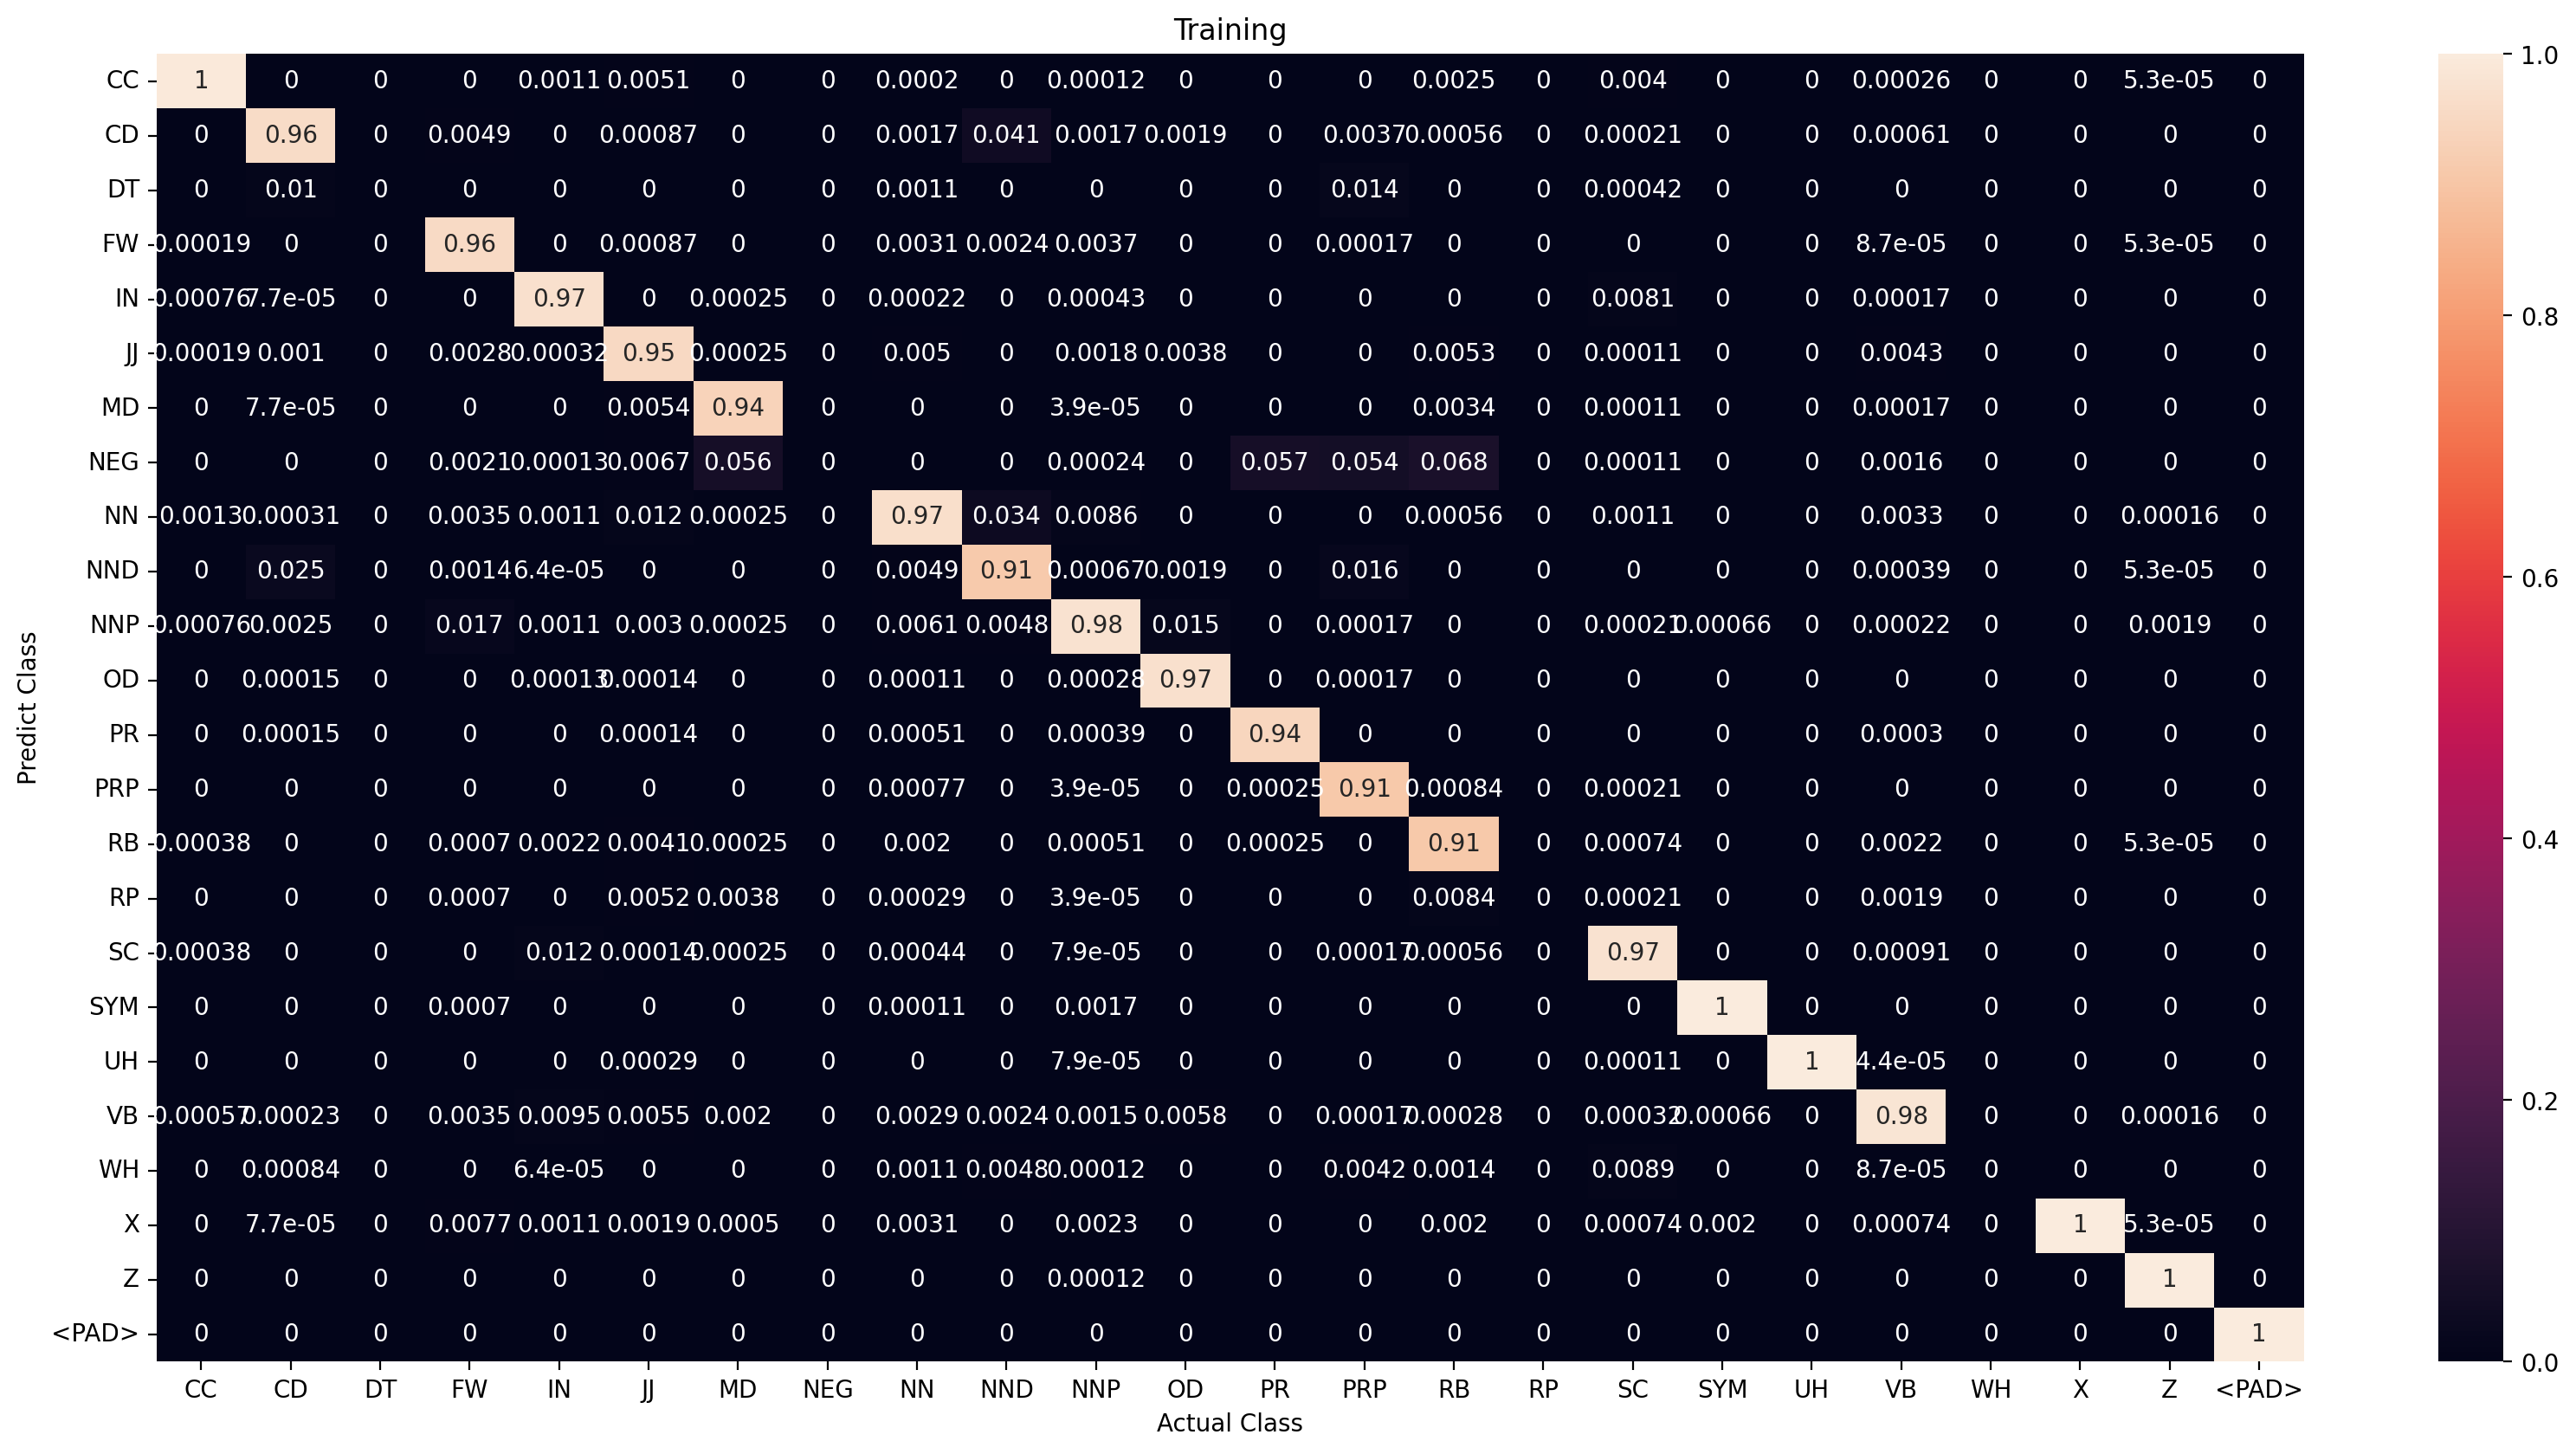

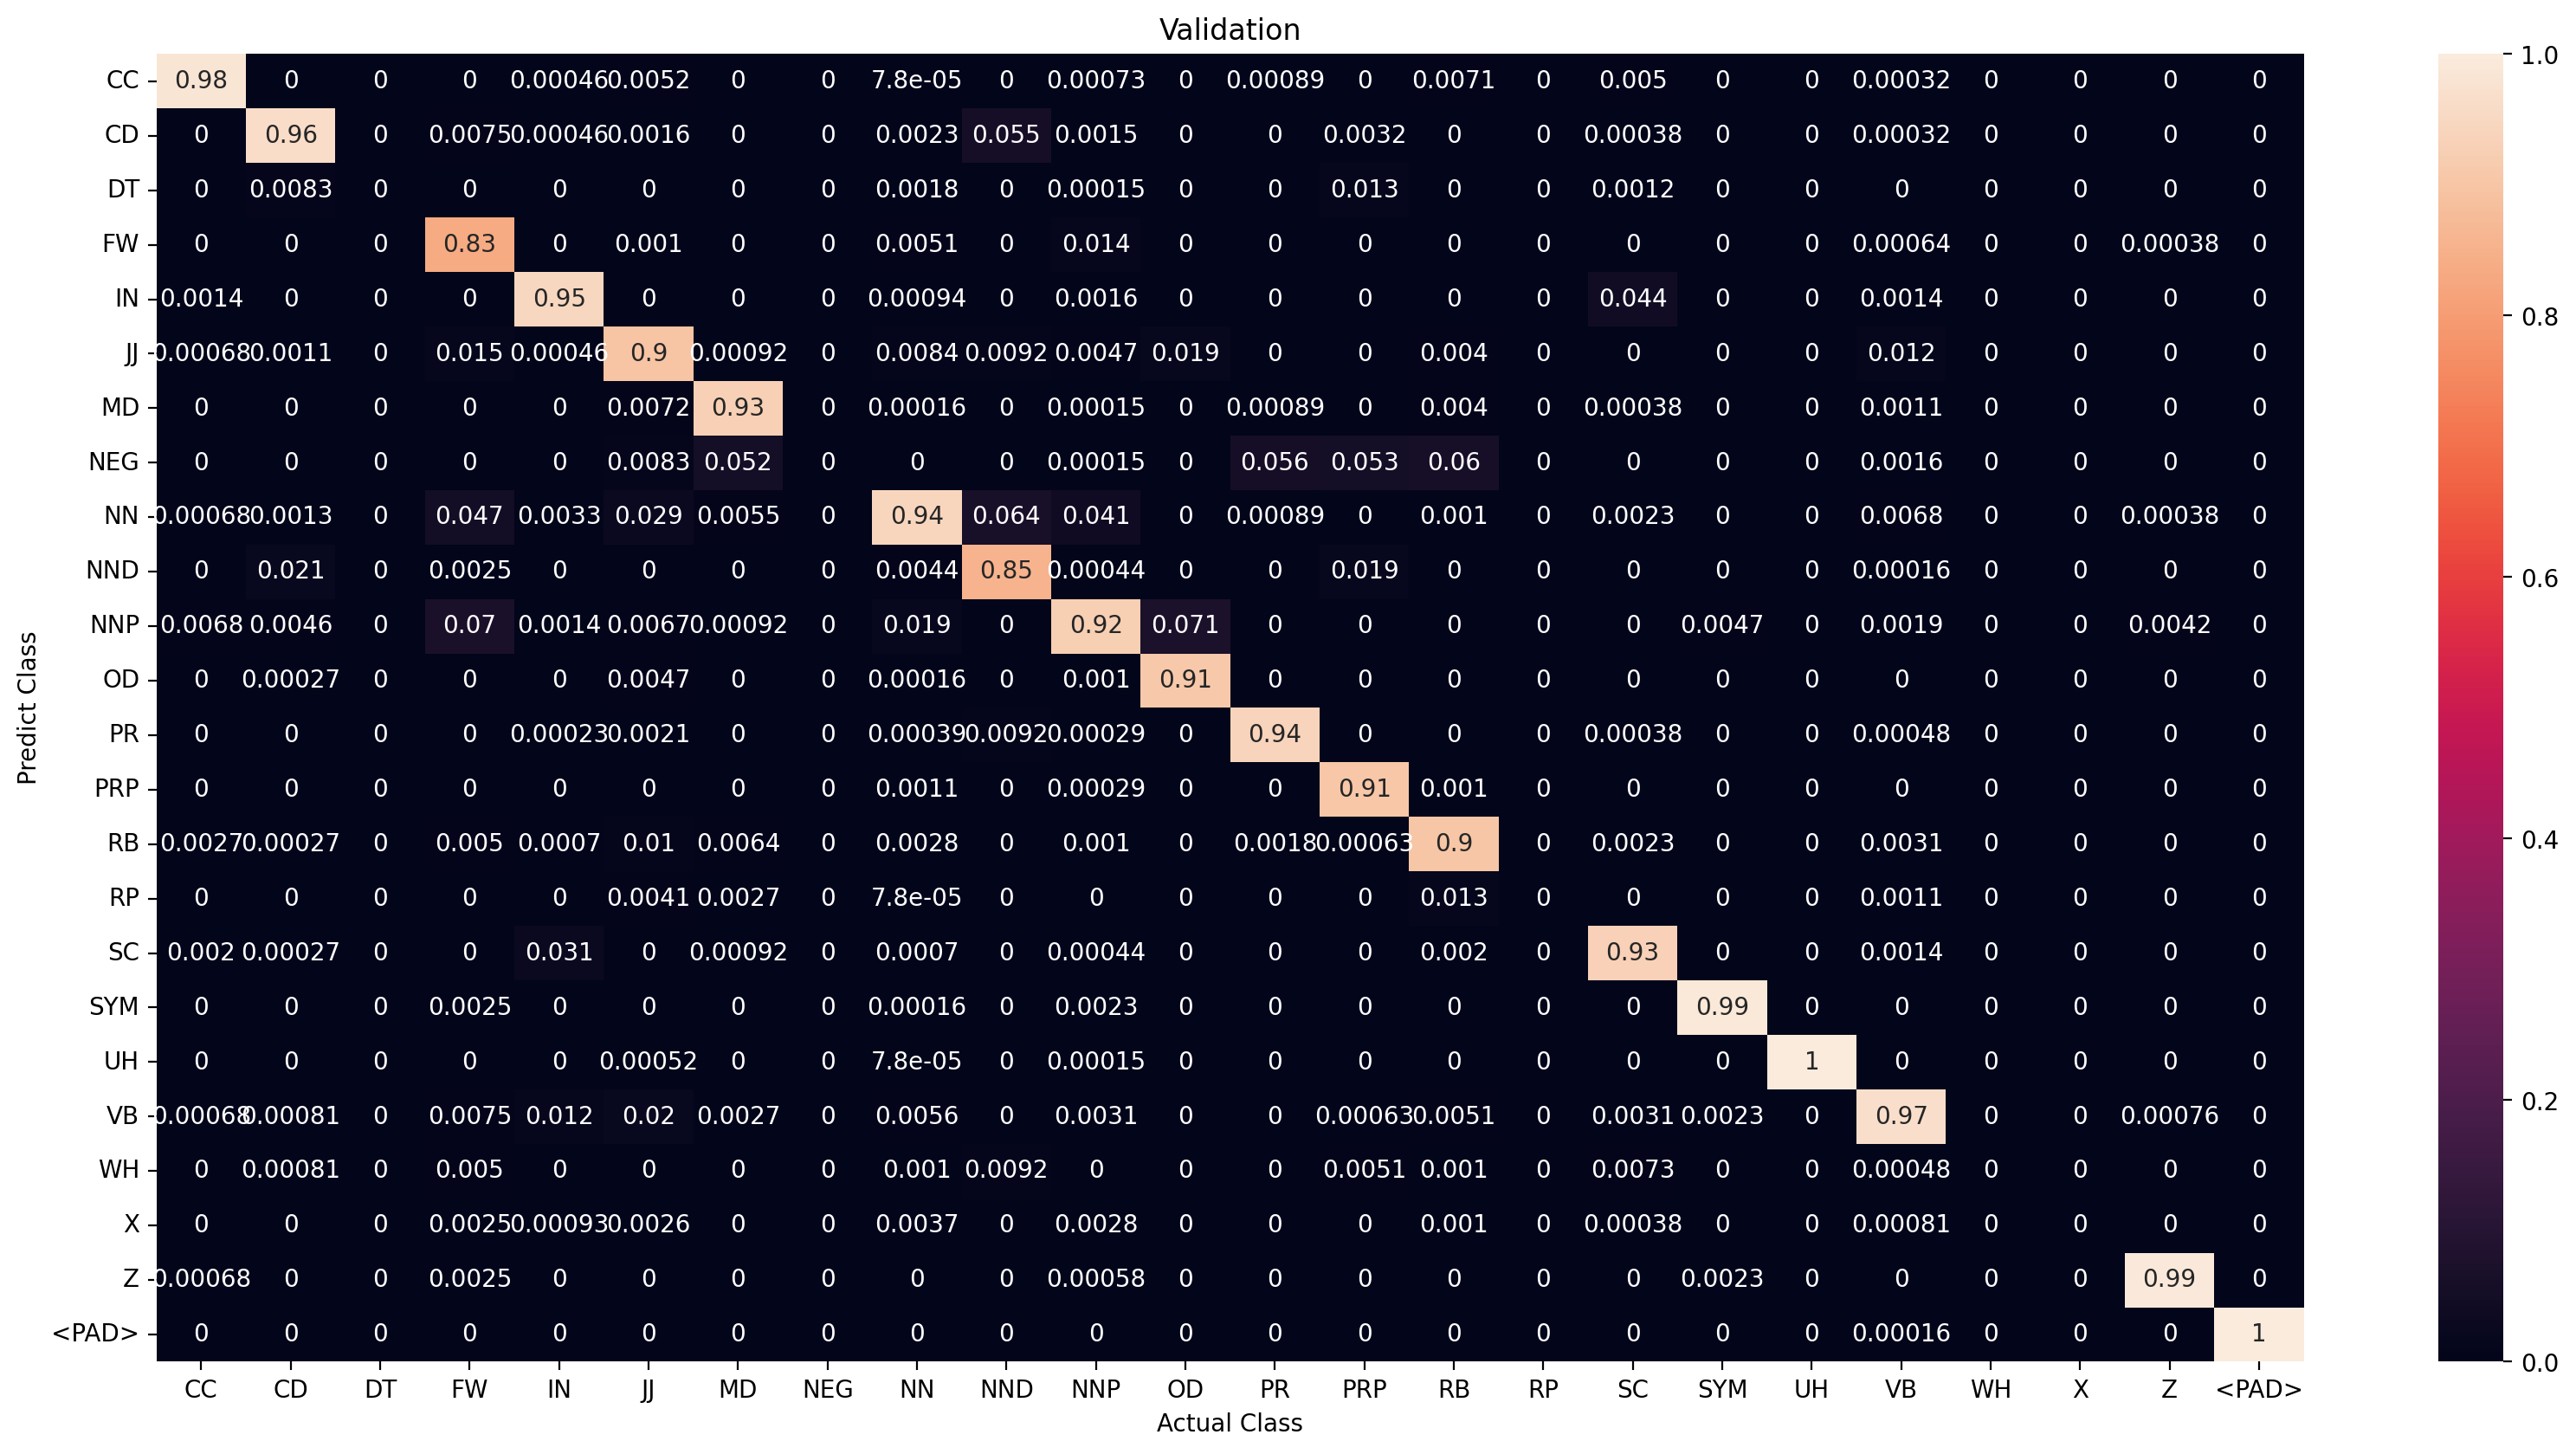

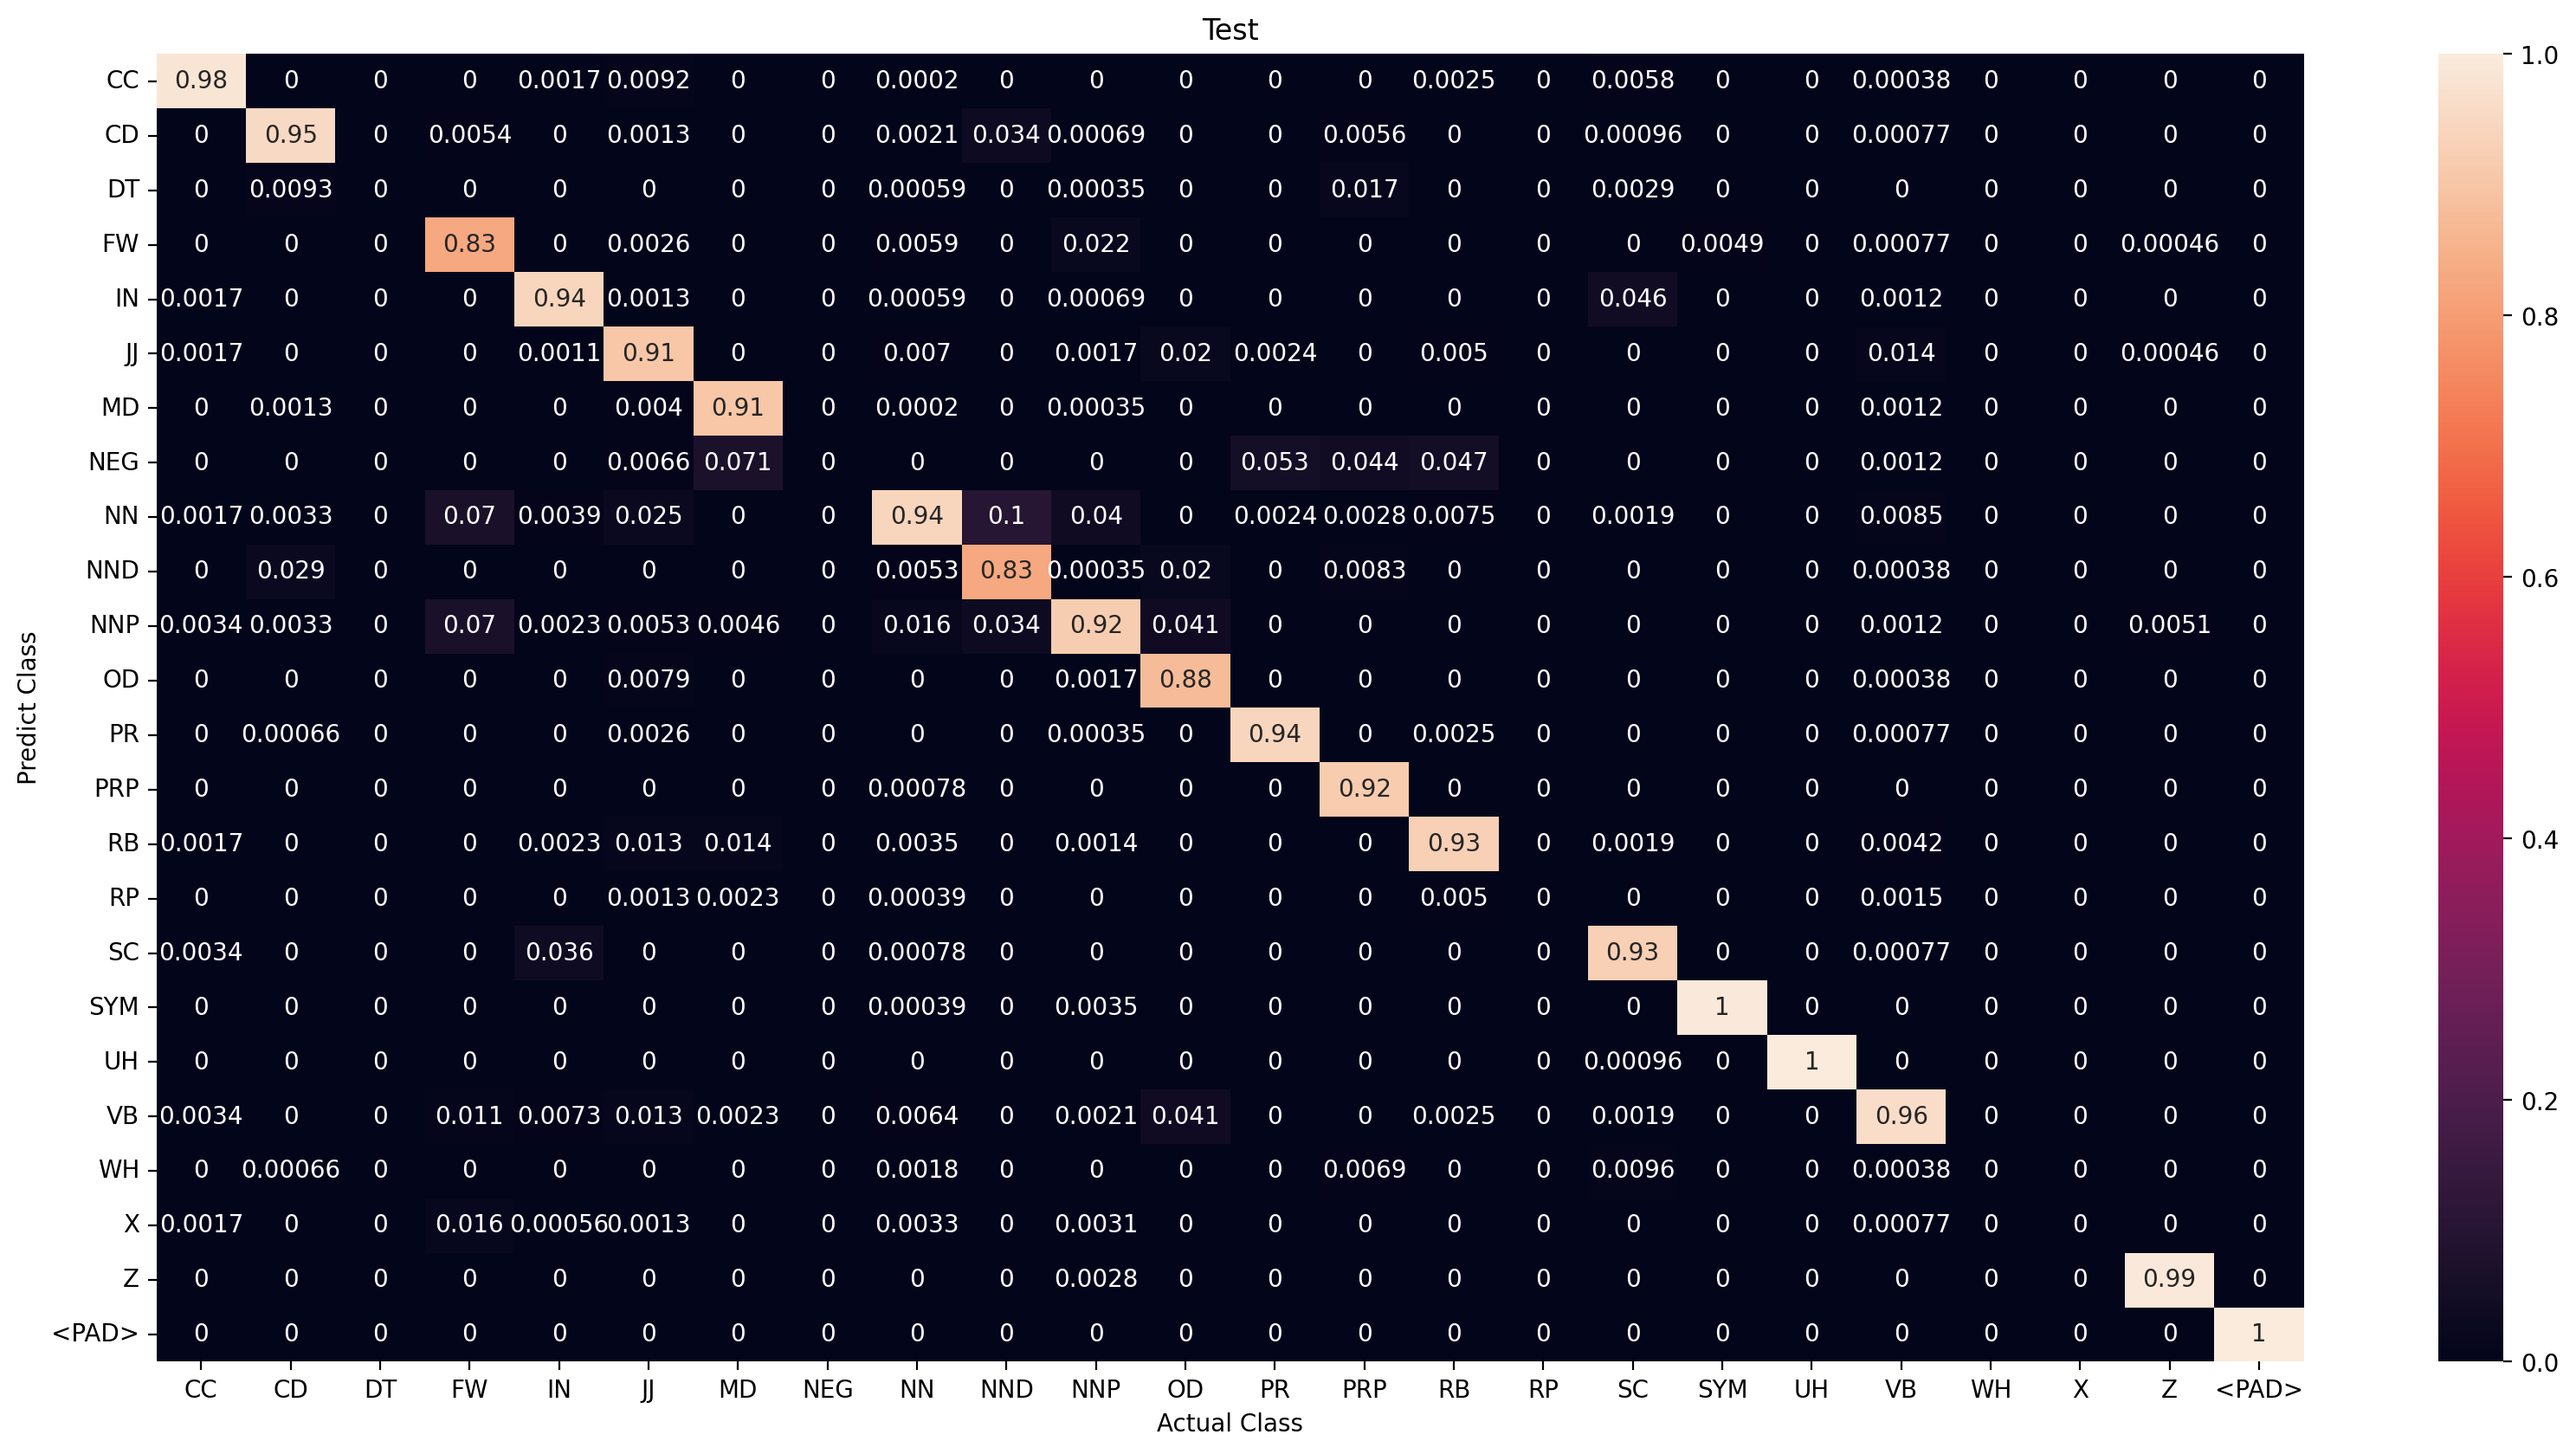

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5346   | CC    : 5228       | CC    : 118      |
| CD    : 12730  | CD    : 12537      | CD    : 193      |
| DT    : 269    | DT    : 0          | DT    : 269      |
| FW    : 1614   | FW    : 1368       | FW    : 246      |
| IN    : 15342  | IN    : 15234      | IN    : 108      |
| JJ    : 6981   | JJ    : 6561       | JJ    : 420      |
| MD    : 3799   | MD    : 3743       | MD    : 56       |
| NEG   : 1118   | NEG   : 0          | NEG   : 1118     |
| NN    : 44369  | NN    : 43933      | NN    : 436      |
| NND   : 1047   | NND   : 377        | NND   : 670      |
| NNP   : 25175  | NNP   : 24742      | NNP   : 433      |
| OD    : 524    | OD    : 506        | OD    : 18       |
| PR    : 3880   | PR    : 3837       | PR    : 43       |
| PRP   : 5471   | PRP   : 5429       | PRP   : 42       |
| RB    : 3477   | RB    : 3246       | RB    : 231      |
| RP    : 141    | RP    : 0          | RP    : 141     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11806
Correct prediction          : 10950
Wrong prediction            : 856
Percentage correct oov pred : 92.74944943249194

Validation
Number OOV token            : 3366
Correct prediction          : 2944
Wrong prediction            : 422
Percentage correct oov pred : 87.46286393345217

Test
Number OOV token            : 1390
Correct prediction          : 1221
Wrong prediction            : 169
Percentage correct oov pred : 87.84172661870504



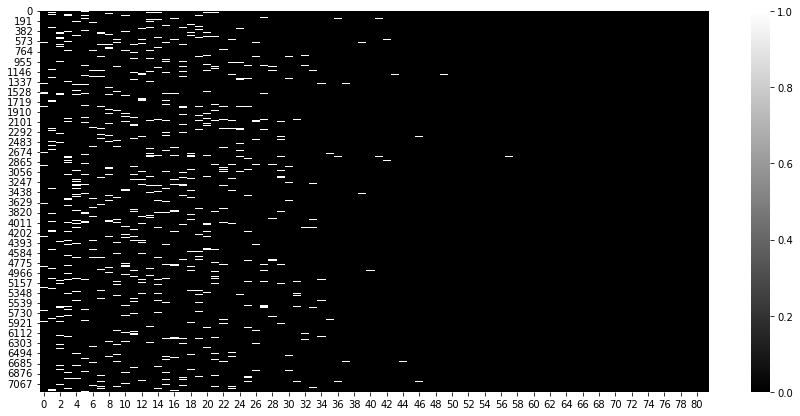

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

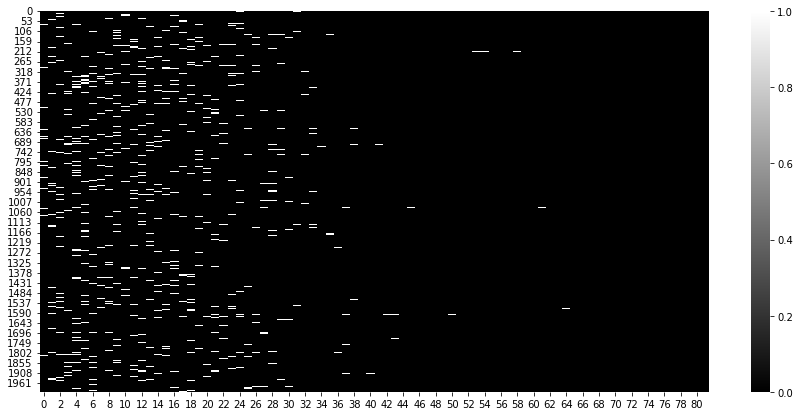

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

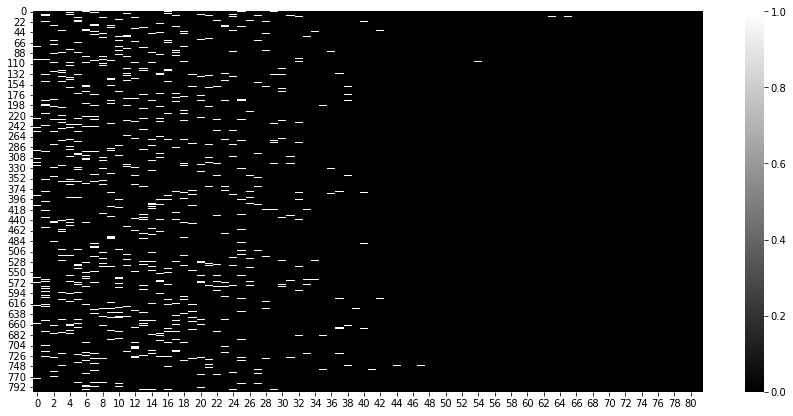

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);